# Import dataset

In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [283]:
df = pd.read_csv('marketing_campaign_data.csv')

# Data Details
Data were uploaded in 2020. sources <a href='https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign'>here</a>.

- AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
- Complain - 1 if customer complained in the last 2 years
- DtCustomer - date of customer’s enrolment with the company
- Education - customer’s level of education
- Marital - customer’s marital status
- Kidhome - number of small children in customer’s household
- Teenhome - number of teenagers in customer’s household
- Income - customer’s yearly household income
- MntFishProducts - amount spent on fish products in the last 2 years
- MntMeatProducts - amount spent on meat products in the last 2 years
- MntFruits - amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntCoke - amount spent on Coke products in the last 2 years
- MntGoldProds - amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalogue
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through company’s web site
- NumWebVisitsMonth - number of visits to company’s web site in the last month
- Recency - number of days since the last purchase


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

# EDA

## Feature Engineering

In [285]:
#Create frequency column
df['frequency'] = df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases'] + df['NumWebPurchases']

#Create conversion_rate column

df['conversion_rate'] = df['frequency']/df['NumWebVisitsMonth']
df['conversion_rate'] = df['conversion_rate'].map(lambda x: 0 if x==np.inf else 0 if np.isnan(x)==True else x)


#Create age column
df['age'] = 2020 - df['Year_Birth']

#Create age_group
df['age_group'] = df['age'].map(lambda x: 'Teen' if x<20 else 'Adult' if x<40 else 'Middle Age' if x<60 else 'Elder')

#Create childs columns
df['childs'] = df['Kidhome'] + df['Teenhome']

#Create spending columns (total pengeluaran)
df['spending'] = df['MntCoke'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

#Create total_acc_cmp (total accepted campaign)
df['total_acc_cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

#Convert to Dt_Customer to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
data_date = datetime.strptime('01-01-2020','%m-%d-%Y')
df['cutomer_days'] = (data_date - df['Dt_Customer'])
df['cutomer_days'] = df['cutomer_days'].map(lambda x: x.days)

In [286]:
df = df.drop(columns=['Unnamed: 0','ID','Year_Birth','Z_CostContact','Z_Revenue','Kidhome','Teenhome'])

In [287]:
cat = [i for i in df.columns if df[i].nunique() < 10]
num = [i for i in df.columns if (df[i].dtype in ['int64','float64']) & (i not in cat)]
len(cat)

12

## Univariate Analysis

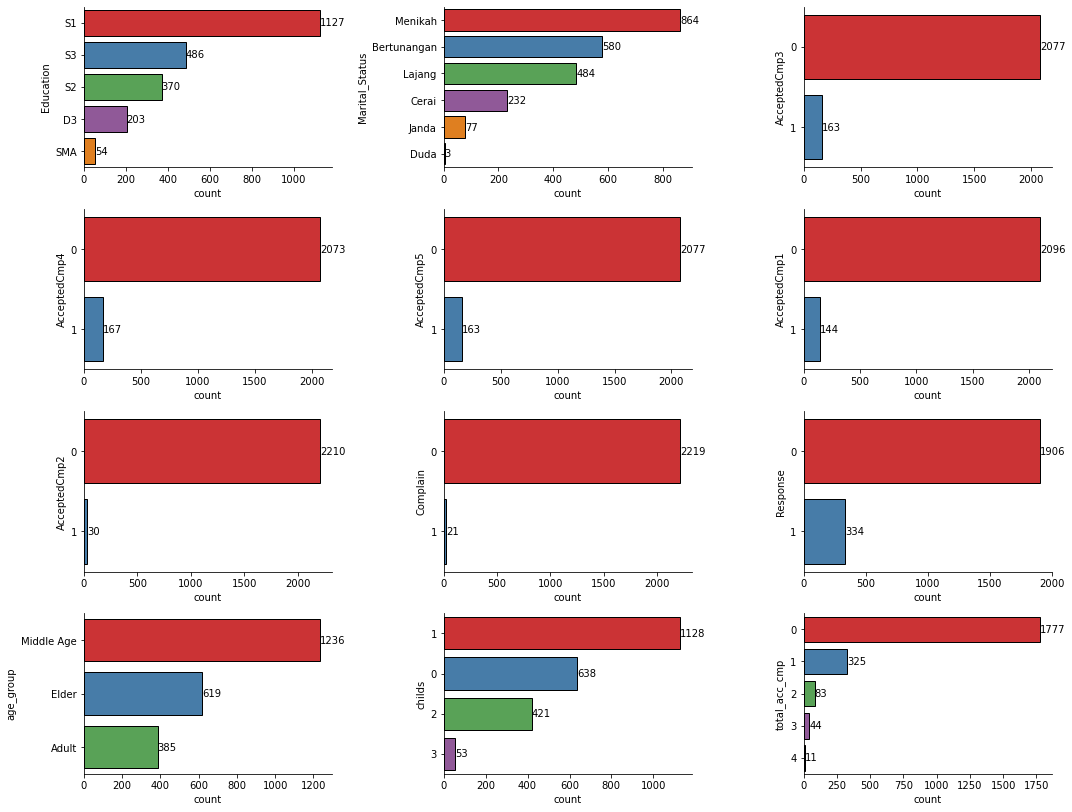

In [288]:
plt.figure(figsize=(15, 25))

for i in range(len(cat)):
    plt.subplot(9, 3, i+1)
    ax = sns.countplot(y=cat[i], data=df, palette='Set1', order=df[cat[i]].value_counts().index,edgecolor='black')
    plt.bar_label(ax.containers[0])

    
sns.despine()
plt.tight_layout()
plt.savefig('univariate.jpg', dpi=400)
plt.show()


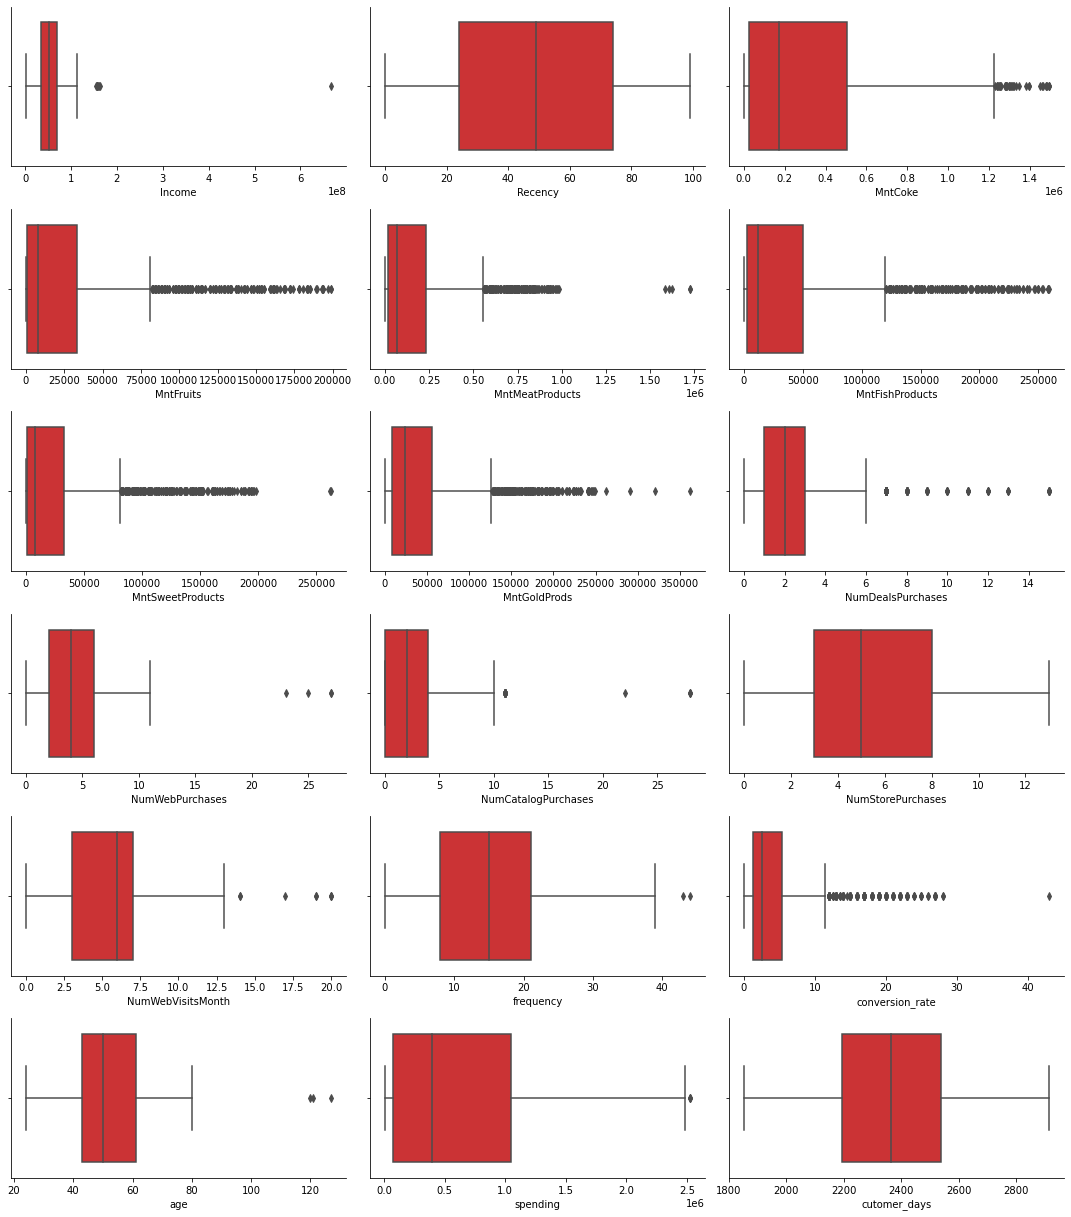

In [289]:
plt.figure(figsize=(15, 25))

for i in range(len(num)):
    plt.subplot(9, 3, i+1)
    ax = sns.boxplot(x=num[i], data=df, palette='Set1')
    

    
sns.despine()
plt.tight_layout()
plt.savefig('univariate_num.jpg', dpi=400)

plt.show()

In [290]:
df['Dt_Customer'].describe()

count                    2240
unique                    663
top       2012-08-31 00:00:00
freq                       12
first     2012-01-08 00:00:00
last      2014-12-06 00:00:00
Name: Dt_Customer, dtype: object

## Multivariate Analysis

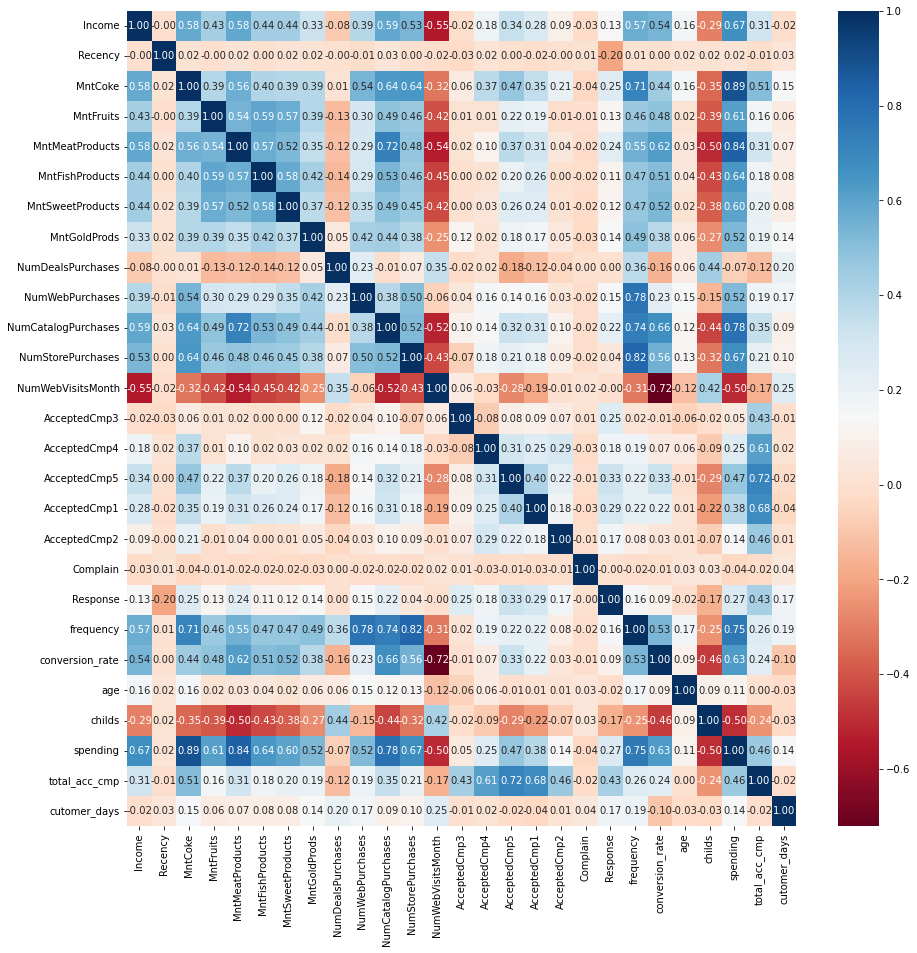

In [291]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap='RdBu', annot=True, fmt='.2f')
plt.show()

### Conversion Rate

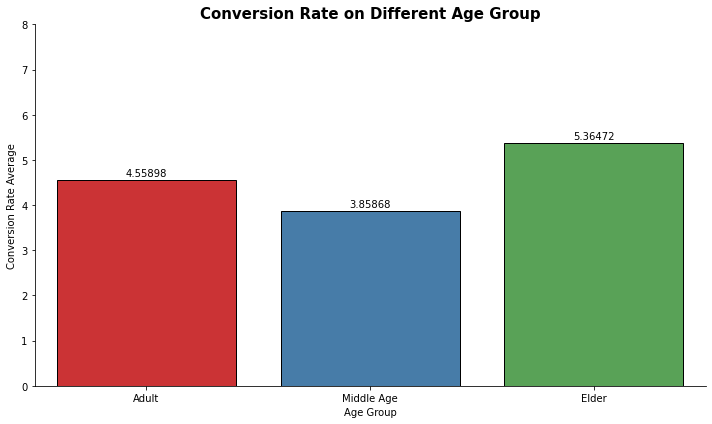

In [292]:
dfg = df.groupby('age_group')['conversion_rate'].mean().reset_index()

fig,ax=plt.subplots(figsize=(10,6))
sns.barplot(data=dfg,x='age_group',y='conversion_rate',edgecolor='black',palette='Set1',order=['Adult','Middle Age','Elder'])
plt.title('Conversion Rate on Different Age Group', fontsize=15, color='black', weight='bold')
plt.bar_label(ax.containers[0], padding=2)
plt.ylim(0,8)
plt.ylabel('Conversion Rate Average')
plt.xlabel('Age Group')

sns.despine()
plt.tight_layout()
plt.savefig('age_group_bar.jpg', dpi=400)

plt.show()

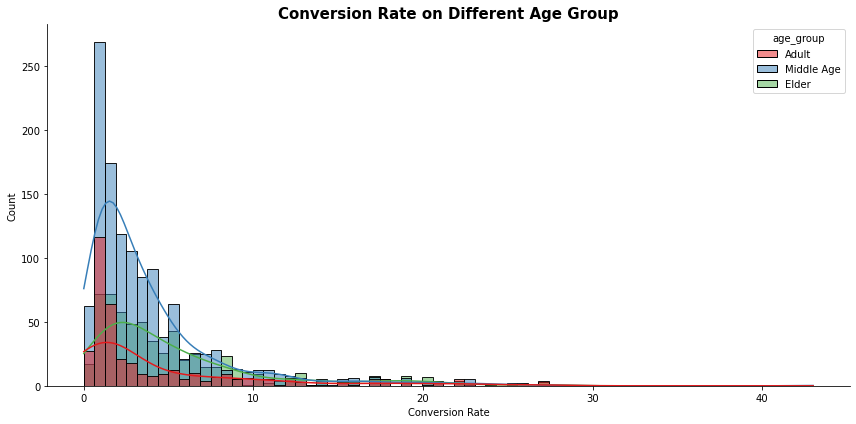

In [293]:
plt.figure(figsize=(12,6))

sns.histplot(data=df,x='conversion_rate',hue='age_group',kde=True,palette='Set1',hue_order=['Adult','Middle Age','Elder'])
plt.title('Conversion Rate on Different Age Group', fontsize=15, color='black', weight='bold')
plt.xlabel('Conversion Rate')

sns.despine()
plt.tight_layout()
plt.savefig('age_group_hist.jpg', dpi=400)
plt.show()

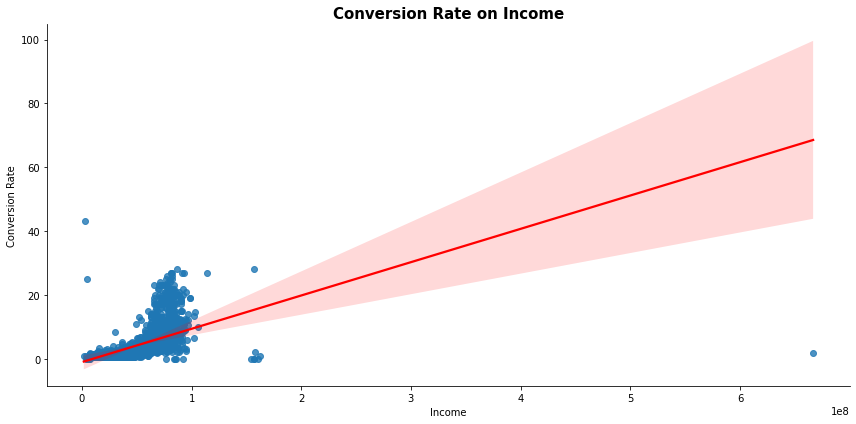

In [294]:
plt.figure(figsize=(12,6))

sns.regplot(data=df,y='conversion_rate',x='Income',line_kws={"color": "red"})

plt.title('Conversion Rate on Income', fontsize=15, color='black', weight='bold')
plt.ylabel('Conversion Rate')
plt.xlabel('Income')

sns.despine()
plt.tight_layout()
plt.savefig('income.jpg', dpi=400)
plt.show()

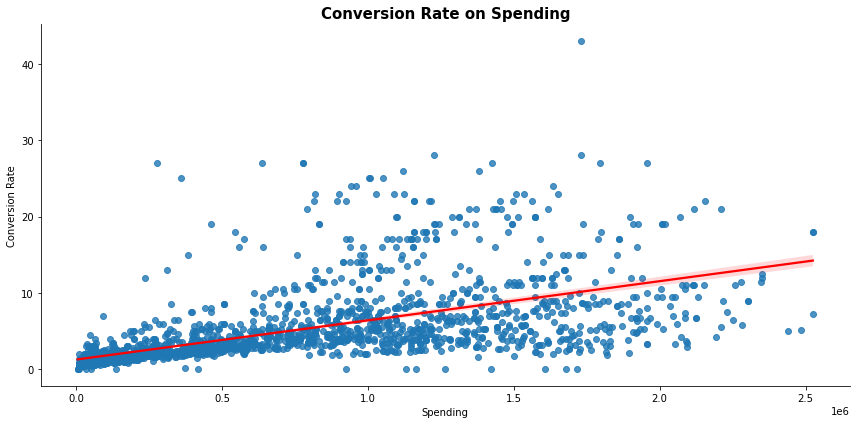

In [295]:
plt.figure(figsize=(12,6))

sns.regplot(data=df,y='conversion_rate',x='spending', line_kws={"color": "red"})

plt.title('Conversion Rate on Spending', fontsize=15, color='black', weight='bold')
plt.ylabel('Conversion Rate')
plt.xlabel('Spending')

sns.despine()
plt.tight_layout()
plt.savefig('spending.jpg', dpi=400)

plt.show()

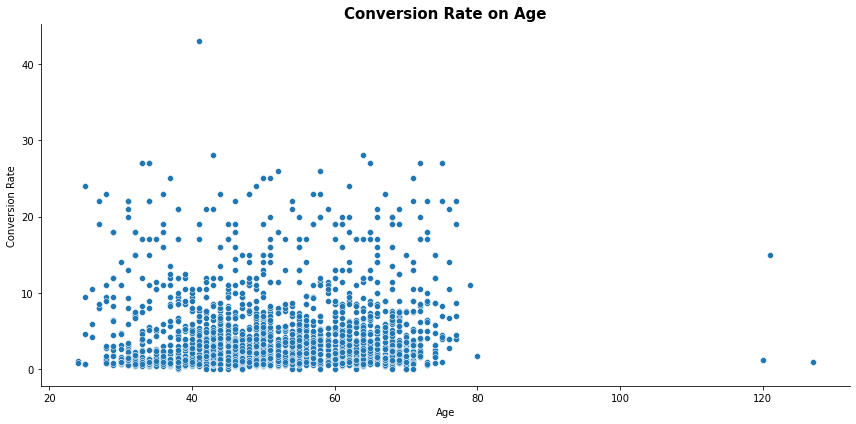

In [296]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=df,y='conversion_rate',x='age')
plt.title('Conversion Rate on Age', fontsize=15, color='black', weight='bold')
plt.ylabel('Conversion Rate')
plt.xlabel('Age')
sns.despine()
plt.tight_layout()
plt.savefig('age_.jpg', dpi=400)
plt.show()

# Data Cleaning

## Missing Values

In [297]:
df.isna().sum()

Education               0
Marital_Status          0
Income                 24
Dt_Customer             0
Recency                 0
MntCoke                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
frequency               0
conversion_rate         0
age                     0
age_group               0
childs                  0
spending                0
total_acc_cmp           0
cutomer_days            0
dtype: int64

In [298]:
#Fill missing values with median
df['Income'] = df['Income'].fillna(df['Income'].median())

## Duplicated Values

In [299]:
df.duplicated().sum()

183

In [300]:
#Check duplicates
df[df.duplicated(keep=False)].sort_values(by='Income').head()

,Education,Marital_Status,Income,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,frequency,conversion_rate,age,age_group,childs,spending,total_acc_cmp,cutomer_days
30,S2,Cerai,10979000.0,2014-05-22,34,8000,4000,10000,2000,2000,...,0,0,8,1.600000,31,Adult,0,30000,0,2050
1138,S2,Cerai,10979000.0,2014-05-22,34,8000,4000,10000,2000,2000,...,0,0,8,1.600000,31,Adult,0,30000,0,2050
1203,S1,Cerai,15287000.0,2012-10-10,60,1000,2000,8000,4000,3000,...,0,1,6,0.857143,41,Middle Age,1,31000,1,2639
260,S1,Cerai,15287000.0,2012-10-10,60,1000,2000,8000,4000,3000,...,0,1,6,0.857143,41,Middle Age,1,31000,1,2639
558,D3,Menikah,15315000.0,2013-03-08,27,7000,4000,13000,15000,8000,...,0,0,8,1.600000,50,Middle Age,0,64000,0,2490


In [301]:
#drop duplicated
df = df.drop_duplicates()

## Drop Unnecesary Columns

In [302]:
df = df.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
                'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'Dt_Customer',
                'MntCoke','MntFishProducts','MntFruits','MntMeatProducts','MntSweetProducts', 'MntGoldProds','Response'],axis=1)

# Data Preprocessing

## Encoding

In [303]:
df.head()

,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Complain,frequency,conversion_rate,age,age_group,childs,spending,total_acc_cmp,cutomer_days
0,S1,Lajang,58138000.0,58,7,0,25,3.571429,63,Elder,0,1617000,0,2823
1,S1,Lajang,46344000.0,38,5,0,6,1.200000,66,Elder,2,27000,0,1977
2,S1,Bertunangan,71613000.0,26,4,0,21,5.250000,55,Middle Age,0,776000,0,2324
3,S1,Bertunangan,26646000.0,26,6,0,8,1.333333,36,Adult,1,53000,0,1917
4,S3,Menikah,58293000.0,94,5,0,19,3.800000,39,Adult,1,422000,0,2173


In [304]:
#Encode education and age group
df['Education'] = df['Education'].map({'SMA':1,'D3':2,'S1':3,'S2':4,'S3':5})
df['age_group'] = df['age_group'].map({'Adult':1,'Middle Age':2,'Elder':3})

In [305]:
#One Hot Encoding 
df = pd.get_dummies(df, columns=['Marital_Status'])
df.head()

,Education,Income,Recency,NumWebVisitsMonth,Complain,frequency,conversion_rate,age,age_group,childs,spending,total_acc_cmp,cutomer_days,Marital_Status_Bertunangan,Marital_Status_Cerai,Marital_Status_Duda,Marital_Status_Janda,Marital_Status_Lajang,Marital_Status_Menikah
0,3,58138000.0,58,7,0,25,3.571429,63,3,0,1617000,0,2823,0,0,0,0,1,0
1,3,46344000.0,38,5,0,6,1.200000,66,3,2,27000,0,1977,0,0,0,0,1,0
2,3,71613000.0,26,4,0,21,5.250000,55,2,0,776000,0,2324,1,0,0,0,0,0
3,3,26646000.0,26,6,0,8,1.333333,36,1,1,53000,0,1917,1,0,0,0,0,0
4,5,58293000.0,94,5,0,19,3.800000,39,1,1,422000,0,2173,0,0,0,0,0,1


## Feature selection

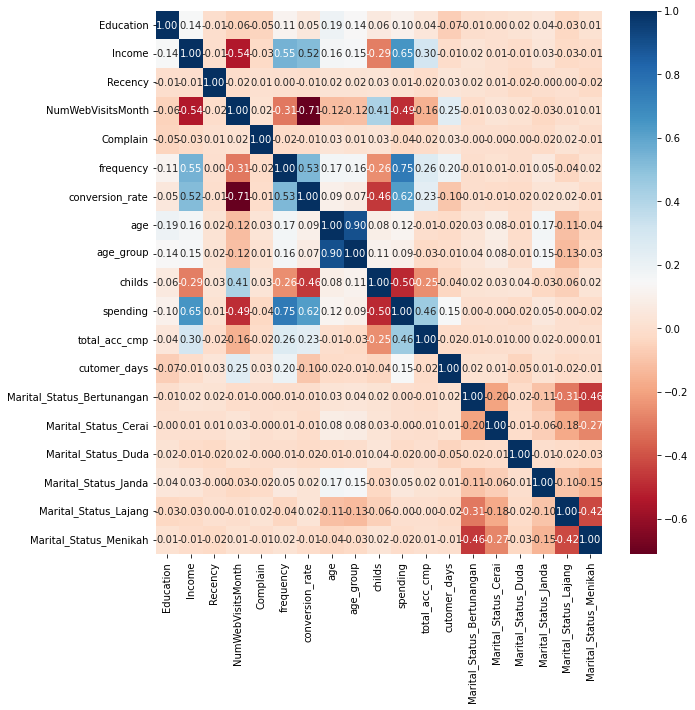

In [306]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='RdBu', annot=True, fmt='.2f')
plt.savefig('corr.jpg', dpi=400)
plt.show()

Kolom yang dipilih berdasarkan correlation plot adalah :
- Recency
- frequency
- spending
- age
- Income
- childs
- total_acc_cmp
- conversion_rate

In [307]:
df.columns

Index(['Education', 'Income', 'Recency', 'NumWebVisitsMonth', 'Complain',
       'frequency', 'conversion_rate', 'age', 'age_group', 'childs',
       'spending', 'total_acc_cmp', 'cutomer_days',
       'Marital_Status_Bertunangan', 'Marital_Status_Cerai',
       'Marital_Status_Duda', 'Marital_Status_Janda', 'Marital_Status_Lajang',
       'Marital_Status_Menikah'],
      dtype='object')

In [308]:
# df_new = df[['Recency','frequency','spending','age','Income','childs','total_acc_cmp']]
# df_new = df[['conversion_rate','frequency','spending','Income','childs','total_acc_cmp','NumWebVisitsMonth']]
df_new = df[['Recency','frequency','spending','age','Income']]


df_new.head()

,Recency,frequency,spending,age,Income
0,58,25,1617000,63,58138000.0
1,38,6,27000,66,46344000.0
2,26,21,776000,55,71613000.0
3,26,8,53000,36,26646000.0
4,94,19,422000,39,58293000.0


## Handling Outliers

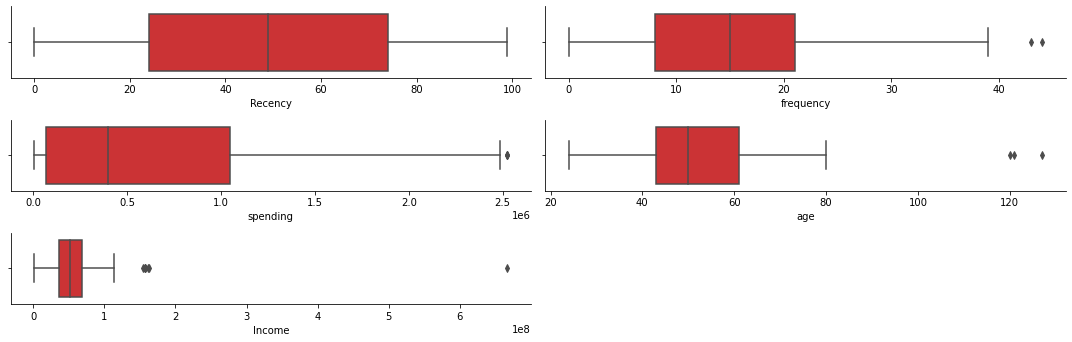

In [309]:
plt.figure(figsize=(15, 6))

for i in range(len(df_new.columns)):
    plt.subplot(4, 2, i+1)
    ax = sns.boxplot(x=df_new.columns[i], data=df_new, palette='Set1')
    
sns.despine()
plt.tight_layout()
plt.savefig('outliers_before.jpg', dpi=400)
plt.show()

Kita akan melakukan handling outliers pada kolom : 
- frequency
- spending
- age
- Income

In [310]:
df_new.shape

(2057, 5)

In [311]:
#Handling outliers
def zscore_handling(x):
    global df_new
    z_score = np.abs(stats.zscore(df_new[x]))
    filtered = (z_score < 3)
    df_new = df_new[filtered]

outliers = ['frequency','spending','age','Income']
for i in outliers:
    zscore_handling(i)

In [312]:
df_new.shape

(2039, 5)

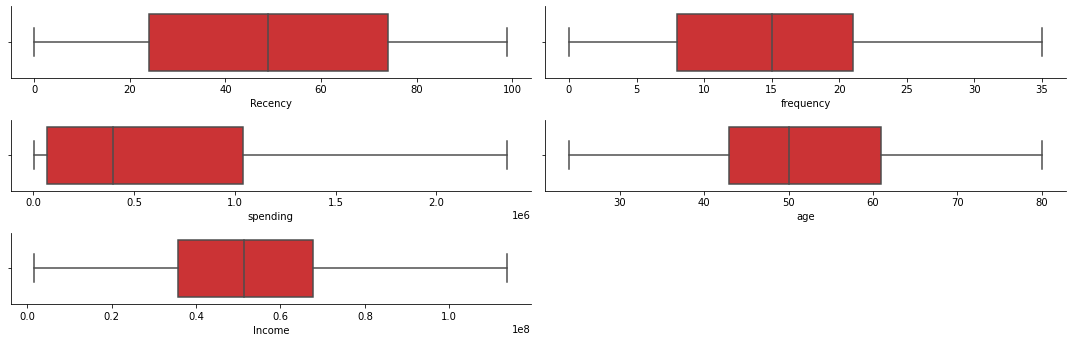

In [313]:
plt.figure(figsize=(15, 6))

for i in range(len(df_new.columns)):
    plt.subplot(4, 2, i+1)
    ax = sns.boxplot(x=df_new.columns[i], data=df_new, palette='Set1')
    
sns.despine()
plt.tight_layout()
plt.savefig('outliers_after.jpg', dpi=400)

plt.show()

## Transformation

In [314]:
#Standarisasi dataset baru
X = df_new.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_new.columns)
df_std.head()

,Recency,frequency,spending,age,Income
0,0.311875,1.345940,1.709489,1.016900,0.317776
1,-0.378023,-1.168312,-0.964801,1.274345,-0.256815
2,-0.791962,0.816624,0.294974,0.330381,0.974263
3,-0.791962,-0.903654,-0.921070,-1.300102,-1.216479
4,1.553692,0.551966,-0.300433,-1.042657,0.325327


# Modelling

## Elbow Method

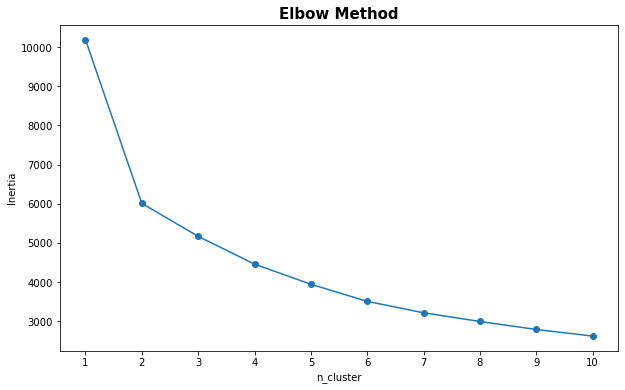

In [315]:
#Elbow method
inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df_std.values)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.xticks(list(range(1,11)))
plt.plot(range(1,11),inertia,marker='o')
plt.title('Elbow Method', fontsize=15, color='black', weight='bold')
plt.xlabel('n_cluster')
plt.ylabel('Inertia')

plt.show()

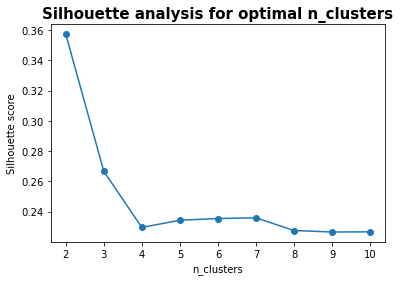

In [316]:
n_clust = list(range(2,11))
silhouette_avg = []
for i in n_clust:
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    
    labels = kmeans.fit_predict(X_std)
    silhouette_avg.append(silhouette_score(X_std,labels))
    
plt.plot(n_clust,silhouette_avg,marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for optimal n_clusters', fontsize=15, color='black', weight='bold')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3571841965585438
For n_clusters = 3 The average silhouette_score is : 0.2666120467543107
For n_clusters = 4 The average silhouette_score is : 0.22958642564138385
For n_clusters = 5 The average silhouette_score is : 0.2343536274398878


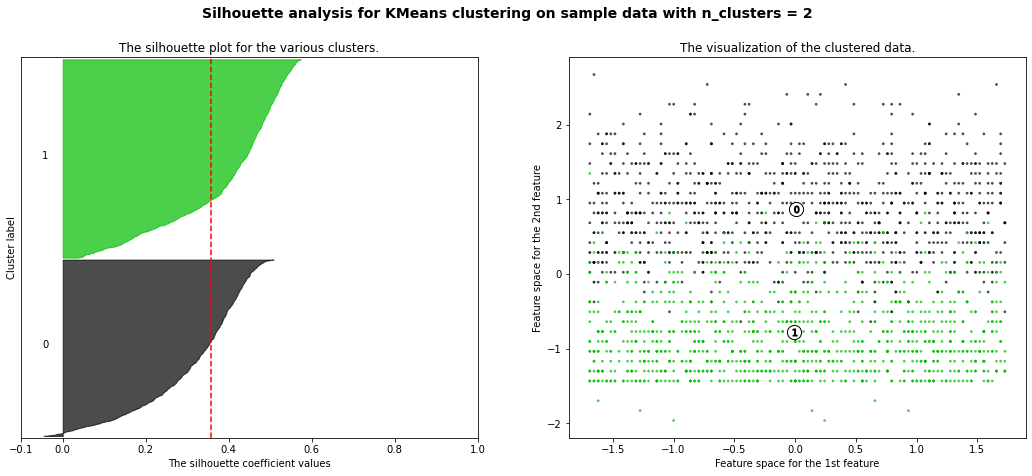

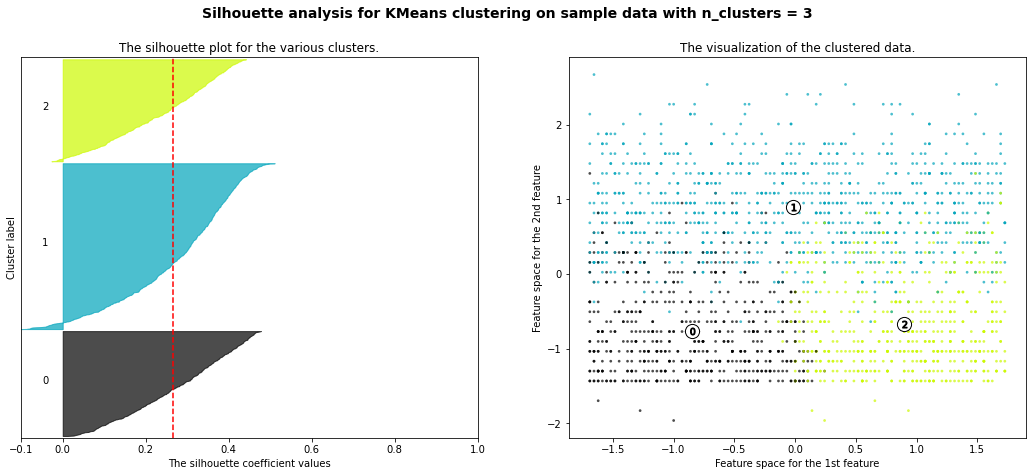

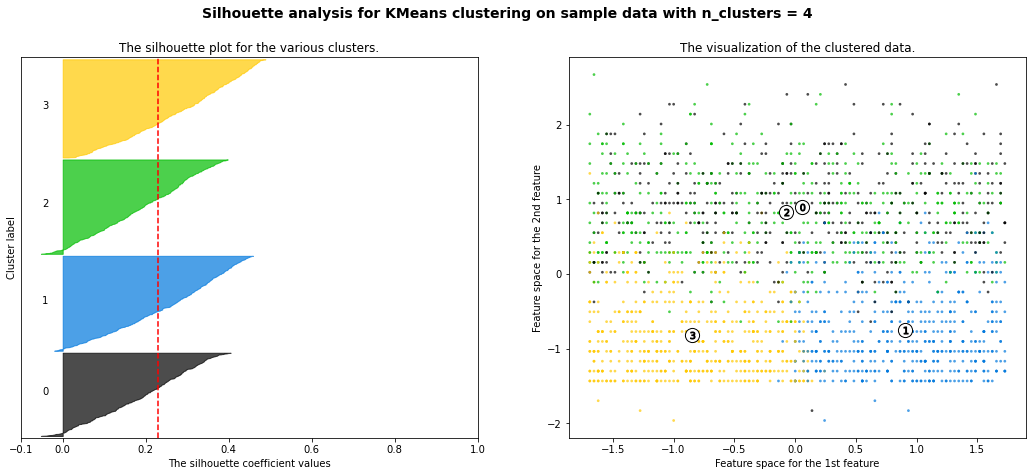

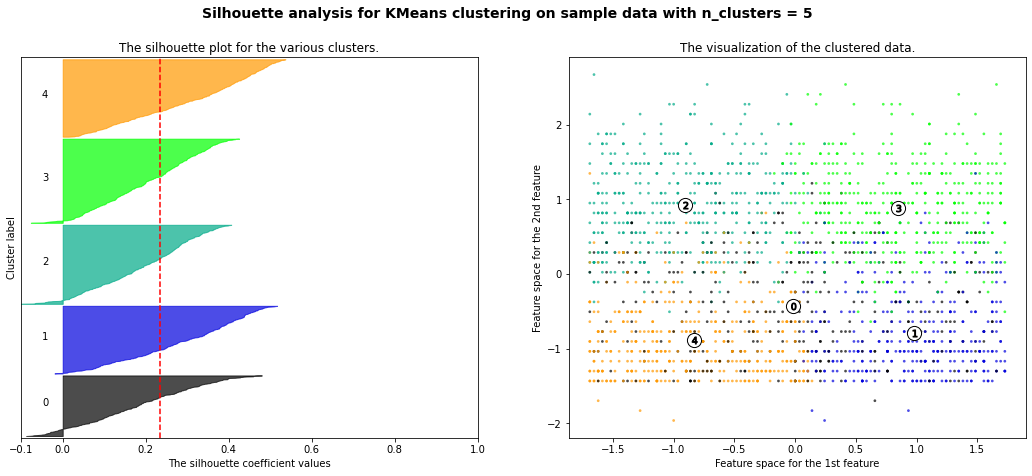

In [317]:
range_n_clusters = [2,3,4,5]
X = X_std
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',max_iter=300,n_init=10,random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [318]:
# Kmeans n_cluster = 3
#Clustering Kmeans
kmeans_3 = KMeans(n_clusters=3,init='k-means++',max_iter=300,n_init=10,random_state=0)
kmeans_3.fit(X_std)

#Tambah clusters label pada dataset
df_cl3 = pd.DataFrame(data=X_std,columns=df_new.columns)
df_cl3['cluster'] = kmeans_3.labels_
df_cl3.sample(3)

,Recency,frequency,spending,age,Income,cluster
2022,1.346723,-1.432970,-0.983302,1.274345,-0.721446,2
680,1.622682,-0.109679,0.584269,1.789235,0.719073,1
391,1.174248,-0.242008,-0.736057,-0.441953,-0.450277,2


<Figure size 288x288 with 0 Axes>

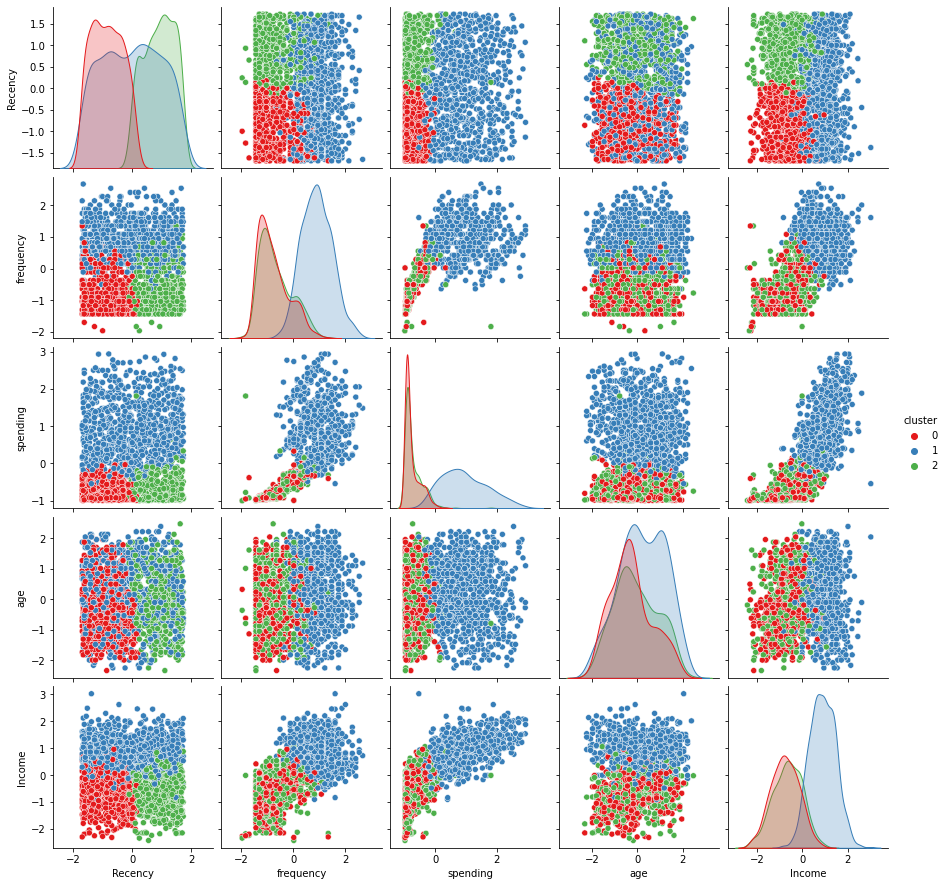

In [319]:
#PLot Before PCA
plt.figure(figsize=(4,4))
sns.pairplot(data=df_cl3,hue='cluster',palette='Set1')
plt.show()

In [320]:
#PCA
pcs_3 = PCA(n_components=2).fit_transform(X_std)
pdf_3 = pd.DataFrame(data=pcs_3,columns=['pc1','pc2'])
pdf_3['cluster'] = df_cl3['cluster']
pdf_3.describe().T

,count,mean,std,min,25%,50%,75%,max
pc1,2039.0,4.004752e-17,1.606337,-3.064728,-1.528372,-0.133235,1.418751,3.933731
pc2,2039.0,-3.147175e-17,1.001701,-2.061248,-0.855218,0.014032,0.866485,2.154024
cluster,2039.0,9.921530e-01,0.745242,0.000000,0.000000,1.000000,2.000000,2.000000


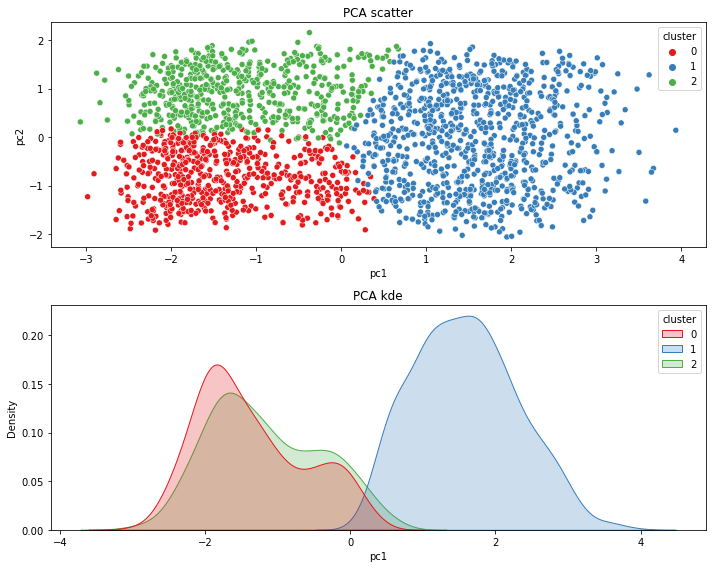

In [321]:
#PCA plot
fig,ax = plt.subplots(2,1,figsize=(10,8))
# plt.figure(figsize=(10,5))
sns.scatterplot(data=pdf_3,x='pc1',y='pc2',hue='cluster',palette='Set1',ax=ax[0])
ax[0].set_title('PCA scatter')
sns.kdeplot(data=pdf_3,x='pc1',hue='cluster',palette='Set1',fill=True,ax=ax[1])
ax[1].set_title('PCA kde')
plt.tight_layout()
plt.show()

# Insight

In [322]:
df_new['cluster'] = kmeans_3.labels_
df_new.groupby('cluster').mean()

,Recency,frequency,spending,age,Income
cluster,,,,,
0,24.303136,9.033101,1.396376e+05,47.811847,3.587488e+07
1,48.538037,21.626240,1.160994e+06,53.717751,6.984404e+07
2,75.005376,9.741935,1.639713e+05,50.410394,3.817740e+07


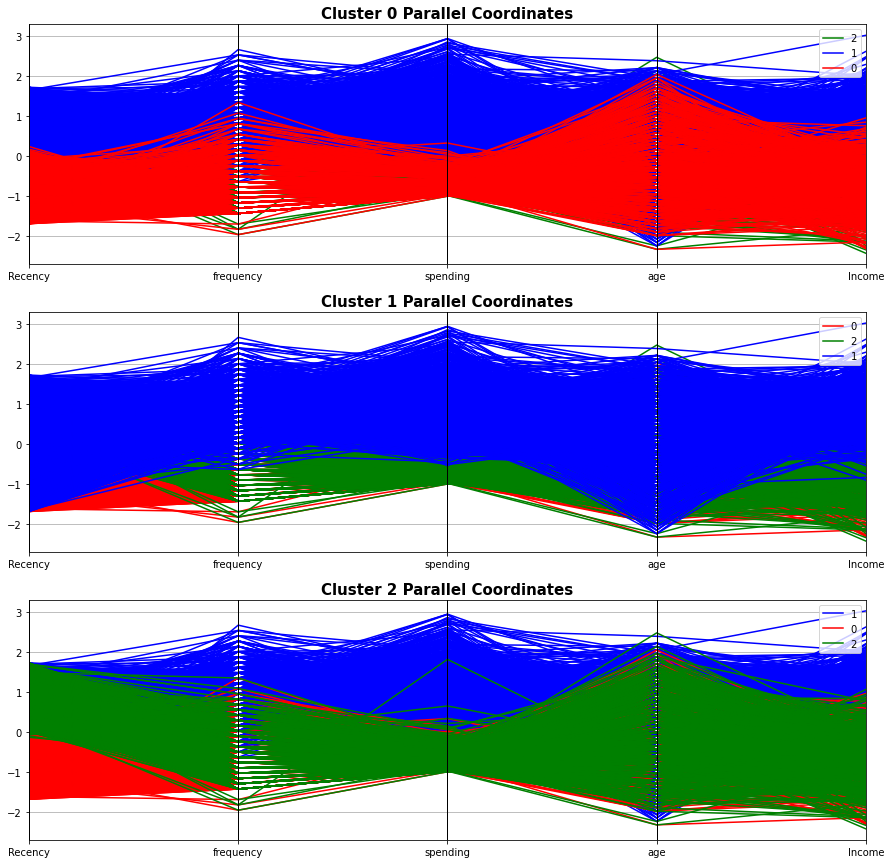

In [323]:
clust_0 = df_cl3[df_cl3['cluster']==0]
clust_1 = df_cl3[df_cl3['cluster']==1]
clust_2 = df_cl3[df_cl3['cluster']==2]
urut = [2,1,0]
clust_color = {0:'r',1:'b',2:'g'}
fig,ax = plt.subplots(3,1,figsize=(15,15))
for i in range(3):
    for j in urut:
        pd.plotting.parallel_coordinates(df_cl3[df_cl3['cluster']==j], 'cluster',color=clust_color[j],ax=ax[i])
    ax[i].set_title(f'Cluster {i} Parallel Coordinates', fontsize=15, color='black', weight='bold')
    urut = urut[-1:]+urut[:-1]

plt.show()

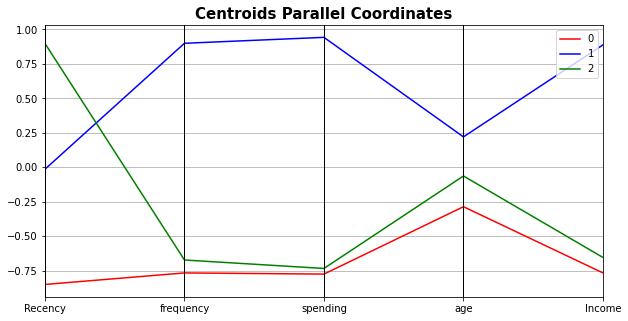

In [324]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans_3.cluster_centers_, columns=df_std.columns)
centroids['cluster'] = centroids.index

plt.figure(figsize=(10,5))
pd.plotting.parallel_coordinates(centroids, 'cluster',color=('r','b','g'))
plt.title('Centroids Parallel Coordinates', fontsize=15, color='black', weight='bold')
plt.show()

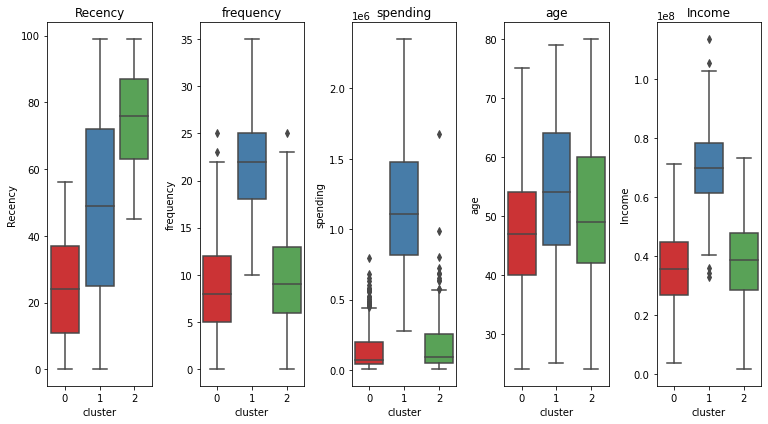

In [325]:
plt.figure(figsize=(15, 6))
df_new['cluster'] = df_new['cluster'].astype('category')
for i in range(len(df_new.columns[:-1])):
    plt.subplot(1, 7, i+1)
    # ax = sns.boxplot(x=df_new.columns[:-1][i], data=df_new, palette='Set1')
    sns.boxplot(data=df_new, x='cluster',y=df_new.columns[:-1][i],palette='Set1')
    plt.title(df_new.columns[:-1][i])
    
# sns.despine()
plt.tight_layout()
# plt.savefig('outliers_before.jpg', dpi=400)
plt.show()

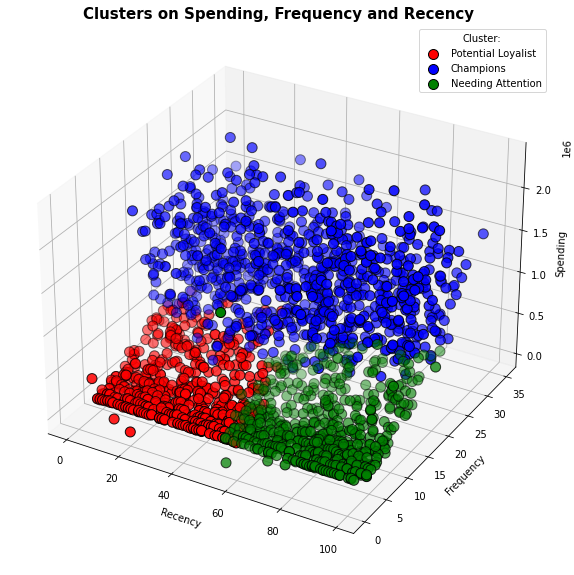

In [326]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.title("Clusters on Spending, Frequency and Recency", fontsize=15, weight='bold')
ax.scatter(df_new['Recency'][df_new.cluster == 0], df_new['frequency'][df_new.cluster == 0], df_new['spending'][df_new.cluster == 0], c='r', s=100, edgecolor='black', label='Potential Loyalist')
ax.scatter(df_new['Recency'][df_new.cluster == 1], df_new['frequency'][df_new.cluster == 1], df_new['spending'][df_new.cluster == 1], c='b', s=100, edgecolor='black', label='Champions')
ax.scatter(df_new['Recency'][df_new.cluster == 2], df_new['frequency'][df_new.cluster == 2], df_new['spending'][df_new.cluster == 2], c='g', s=100, edgecolor='black', label='Needing Attention')

plt.xlabel('Recency')
plt.ylabel('Frequency')
ax.set_zlabel('Spending')
plt.legend(title='Cluster:')
plt.show()

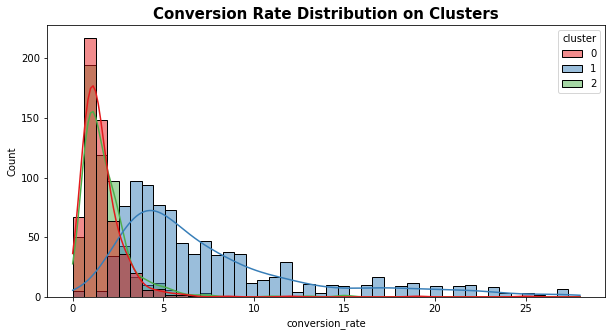

In [327]:
df_c = df[['conversion_rate']].reset_index()
df_a = df_new.reset_index()
df_b = df_a.merge(df_c,how='left',on='index')
plt.figure(figsize=(10,5))
sns.histplot(data=df_b,x='conversion_rate',hue='cluster',kde=True,palette='Set1')
plt.title('Conversion Rate Distribution on Clusters', fontsize=15, color='black', weight='bold')

plt.show()

In [328]:
num_0 = df_new[df_new['cluster']==0].shape[0]
num_1 = df_new[df_new['cluster']==1].shape[0]
num_2 = df_new[df_new['cluster']==2].shape[0]
num_tot = df_new.shape[0]

print(f'Jumlah customer cluster 0 {num_0} dengan persentase dari keseluruhan {round((num_0/num_tot)*100,2)}%')
print(f'Jumlah customer cluster 1 {num_1} dengan persentase dari keseluruhan {round((num_1/num_tot)*100,2)}%')
print(f'Jumlah customer cluster 2 {num_2} dengan persentase dari keseluruhan {round((num_2/num_tot)*100,2)}%')

Jumlah customer cluster 0 574 dengan persentase dari keseluruhan 28.15%
Jumlah customer cluster 1 907 dengan persentase dari keseluruhan 44.48%
Jumlah customer cluster 2 558 dengan persentase dari keseluruhan 27.37%


In [329]:
df_new[df_new['cluster']==2]['Recency'].mean()

75.00537634408602

In [330]:
df_new[df_new['cluster']==2]['frequency'].mean()

9.741935483870968

In [331]:
df_new[df_new['cluster']==2]['spending'].mean()

163971.32616487454

In [332]:
df_new[df_new['cluster']==2]['age'].quantile(0.25)

42.0

In [333]:
df_new[df_new['cluster']==2]['age'].quantile(0.75)

60.0

In [334]:
df_new[df_new['cluster']==2]['Income'].mean()

38177403.22580645